In [4]:
import pickle
from collections import deque

import numpy
from matplotlib import pyplot as matpyplot

# Inspecting Transition Recording Files

## Loading the files

In [5]:
FILEPATH_1 = (
    './gnss_test_raw_data_1716472705.1320515_features.pickle'
)

FILEPATH_2 = (
    './gnss_test_raw_data_1716473898.1400812_features.pickle'
)

FILEPATH_3 = (
    './gnss_test_raw_data_1716475018.8516796_features.pickle'
)

FILEPATH_4 = (
    './gnss_test_raw_data_1716535003.8263893_features.pickle'
)

In [6]:
with open(FILEPATH_1, 'rb') as handle:
    f1_gnss_batch_data = pickle.load(handle)
with open(FILEPATH_2, 'rb') as handle:
    f2_gnss_batch_data = pickle.load(handle)
with open(FILEPATH_3, 'rb') as handle:
    f3_gnss_batch_data = pickle.load(handle)
with open(FILEPATH_4, 'rb') as handle:
    f4_gnss_batch_data = pickle.load(handle)


print('Filepath 1')
f1_gnss_batch_data_narray = numpy.array(f1_gnss_batch_data)
print(f1_gnss_batch_data_narray.shape)
print('Filepath 2')
f2_gnss_batch_data_narray = numpy.array(f2_gnss_batch_data)
print(f2_gnss_batch_data_narray.shape)
print('Filepath 3')
f3_gnss_batch_data_narray = numpy.array(f3_gnss_batch_data)
print(f3_gnss_batch_data_narray.shape)
print('Filepath 4')
f4_gnss_batch_data_narray = numpy.array(f4_gnss_batch_data)
print(f4_gnss_batch_data_narray.shape)

Filepath 1
(6483, 20)
Filepath 2
(6800, 20)
Filepath 3
(9979, 20)
Filepath 4
(4401, 20)


## Pre-process raw data

In [7]:
def separate_data_per_batch(gnss_batch_narray):
    batches_ids = gnss_batch_narray[:, 0]
    __, batches_idxs = numpy.unique(batches_ids, return_index=True)
    gnss_data_per_batch = numpy.split(gnss_batch_narray, batches_idxs[1:])

    return gnss_data_per_batch

In [8]:
f1_gnss_data_per_batch = separate_data_per_batch(f1_gnss_batch_data_narray)
print(f'Number of batches divided in F1: {len(f1_gnss_data_per_batch)}')
f2_gnss_data_per_batch = separate_data_per_batch(f2_gnss_batch_data_narray)
print(f'Number of batches divided in F2: {len(f2_gnss_data_per_batch)}')
f3_gnss_data_per_batch = separate_data_per_batch(f3_gnss_batch_data_narray)
print(f'Number of batches divided in F3: {len(f3_gnss_data_per_batch)}')
f4_gnss_data_per_batch = separate_data_per_batch(f4_gnss_batch_data_narray)
print(f'Number of batches divided in F4: {len(f4_gnss_data_per_batch)}')

Number of batches divided in F1: 401
Number of batches divided in F2: 404
Number of batches divided in F3: 499
Number of batches divided in F4: 289


## Extract features of interest

In [9]:
# Features to extract
FEATURES_NAMES = ['CNo Mean', '# Sat.']

In [10]:
def compute_features_gnss_data(
        gnss_data_array,
        n_features=3,
):
    gnss_features = numpy.zeros((len(gnss_data_array), n_features))

    for batch_n, gnss_data_in_batch in enumerate(gnss_data_array):

        cno_mean_batch = gnss_data_in_batch[:, 4].mean()
        nvs_batch = gnss_data_in_batch[0, 13]
        
        gnss_features[batch_n] = numpy.array([
            cno_mean_batch,
            nvs_batch,
        ]).astype(float)

    return gnss_features

In [11]:
f1_gnss_features = compute_features_gnss_data(
    f1_gnss_data_per_batch,
    n_features=len(FEATURES_NAMES),
)
print(f'F1 features shape: {f1_gnss_features.shape}')
f2_gnss_features = compute_features_gnss_data(
    f2_gnss_data_per_batch,
    n_features=len(FEATURES_NAMES),
)
print(f'F2 features shape: {f2_gnss_features.shape}')
f3_gnss_features = compute_features_gnss_data(
    f3_gnss_data_per_batch,
    n_features=len(FEATURES_NAMES),
)
print(f'F3 features shape: {f3_gnss_features.shape}')
f4_gnss_features = compute_features_gnss_data(
    f4_gnss_data_per_batch,
    n_features=len(FEATURES_NAMES),
)
print(f'F4 features shape: {f4_gnss_features.shape}')

F1 features shape: (401, 2)
F2 features shape: (404, 2)
F3 features shape: (499, 2)
F4 features shape: (289, 2)


## Visualizing the features

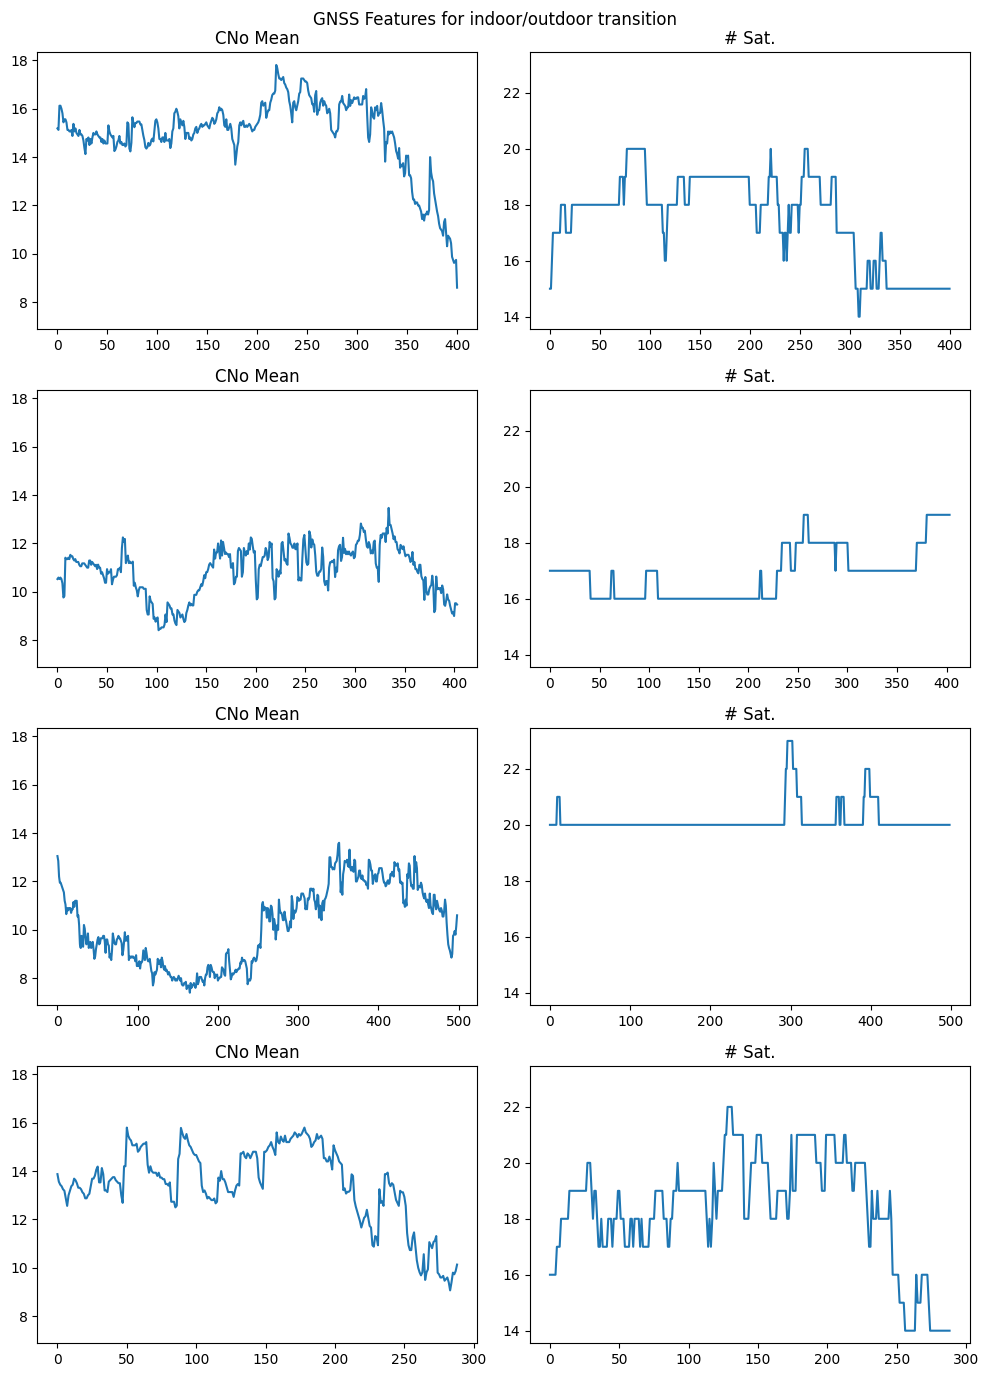

In [12]:
# Rows -> FILES
# Columns -> Features

FILES_TO_PLOT = [
    f1_gnss_features,
    f2_gnss_features,
    f3_gnss_features,
    f4_gnss_features
]


fig, axs = matpyplot.subplots(
    nrows=len(FILES_TO_PLOT),
    ncols=len(FEATURES_NAMES),
    sharey='col',
    figsize=(10, 14)
)
fig.suptitle('GNSS Features for indoor/outdoor transition')
for n, axi in enumerate(axs):
    axi[0].plot(range(0, len(FILES_TO_PLOT[n])), FILES_TO_PLOT[n][:, 0])
    axi[1].plot(range(0, len(FILES_TO_PLOT[n])), FILES_TO_PLOT[n][:, 1])

    axi[0].set_title(FEATURES_NAMES[0])
    axi[1].set_title(FEATURES_NAMES[1])

matpyplot.tight_layout()

## Visualizing main features projection

In [13]:
from gtda.time_series import SingleTakensEmbedding
from sklearn.decomposition import PCA

### Building the embedding

In [14]:
def compute_embedding_from_file(
        file_gnss_features_narray,
        max_embedding_dim,
        max_time_delay,
        stride=1,
        repeat_initial_state=True,
        n_samples_for_initial=90,
        feature_col=0
):
    fn_embedder = SingleTakensEmbedding(
        parameters_type="fixed",
        time_delay=max_time_delay,
        dimension=max_embedding_dim,
        stride=stride,
    )

    f2_gnss_sample = file_gnss_features_narray[
        :n_samples_for_initial, feature_col
    ]

    if repeat_initial_state:
        f2_gnss_sample = numpy.tile(
            f2_gnss_sample, 10
        )
    
    fn_embedder.fit(f2_gnss_sample)

    fn_embedded_train = fn_embedder.transform(
        file_gnss_features_narray[:n_samples_for_initial, feature_col]
    )
    fn_embedded_all = fn_embedder.transform(
        file_gnss_features_narray[:, feature_col]
    )

    return fn_embedder, fn_embedded_train, fn_embedded_all

#### Filepath 1

In [15]:
"""
4 dim -> 1 sec
120 samples -> 30 sec
"""

(
    f1_embedder_cno_mean,
    f1_cno_mean_embedded_train,
    f1_cno_mean_embedded_all
) = compute_embedding_from_file(
    f1_gnss_features,
    max_embedding_dim=3,
    max_time_delay=1,
)

print(f"Shape of embedded time series: {f1_cno_mean_embedded_all.shape}")
print(
    f"Optimal embedding dimension is {f1_embedder_cno_mean.dimension_} and "
    f"time delay is {f1_embedder_cno_mean.time_delay_}"
)

Shape of embedded time series: (399, 3)
Optimal embedding dimension is 3 and time delay is 1


In [16]:
# Examining original features and embedding

print(f1_gnss_features[:12, 0])
print(f1_cno_mean_embedded_all[:3])
print(f1_cno_mean_embedded_all[0])
print(f1_cno_mean_embedded_all[1])

[15.1875 15.125  16.125  16.125  16.     15.8125 15.4375 15.5625 15.5625
 15.4375 15.125  15.125 ]
[[15.1875 15.125  16.125 ]
 [15.125  16.125  16.125 ]
 [16.125  16.125  16.    ]]
[15.1875 15.125  16.125 ]
[15.125 16.125 16.125]


#### Filepath 2, 3, 4

In [17]:
fn_max_embedding_dimension = 3
fn_max_time_delay = 1
stride = 1

In [18]:
(
    f2_embedder_cno_mean,
    f2_cno_mean_embedded_train,
    f2_cno_mean_embedded_all
) = compute_embedding_from_file(
    f2_gnss_features,
    max_embedding_dim=3,
    max_time_delay=1,
)

print(f"Shape of embedded time series: {f2_cno_mean_embedded_all.shape}")
print(
    f"Optimal embedding dimension is {f2_embedder_cno_mean.dimension_} and "
    f"time delay is {f2_embedder_cno_mean.time_delay_}"
)

Shape of embedded time series: (402, 3)
Optimal embedding dimension is 3 and time delay is 1


In [19]:
(
    f3_embedder_cno_mean,
    f3_cno_mean_embedded_train,
    f3_cno_mean_embedded_all
) = compute_embedding_from_file(
    f3_gnss_features,
    max_embedding_dim=3,
    max_time_delay=1,
)

print(f"Shape of embedded time series: {f3_cno_mean_embedded_all.shape}")
print(
    f"Optimal embedding dimension is {f3_embedder_cno_mean.dimension_} and "
    f"time delay is {f3_embedder_cno_mean.time_delay_}"
)

Shape of embedded time series: (497, 3)
Optimal embedding dimension is 3 and time delay is 1


In [20]:
(
    f4_embedder_cno_mean,
    f4_cno_mean_embedded_train,
    f4_cno_mean_embedded_all
) = compute_embedding_from_file(
    f4_gnss_features,
    max_embedding_dim=3,
    max_time_delay=1,
)

print(f"Shape of embedded time series: {f4_cno_mean_embedded_all.shape}")
print(
    f"Optimal embedding dimension is {f4_embedder_cno_mean.dimension_} and "
    f"time delay is {f4_embedder_cno_mean.time_delay_}"
)

Shape of embedded time series: (287, 3)
Optimal embedding dimension is 3 and time delay is 1


### Reducing dimension for 2D plot

In [21]:
def get_2d_features_narray(high_dim_narray):
    features_pca = PCA(n_components=2)
    features_embedded_pca = features_pca.fit_transform(high_dim_narray)

    return features_pca, features_embedded_pca


In [22]:
__, f1_cno_mean_embedded_all_pca = get_2d_features_narray(
    f1_cno_mean_embedded_all
)
print(f1_cno_mean_embedded_all_pca.shape)

__, f2_cno_mean_embedded_all_pca = get_2d_features_narray(
    f2_cno_mean_embedded_all
)
print(f2_cno_mean_embedded_all_pca.shape)

__, f3_cno_mean_embedded_all_pca = get_2d_features_narray(
    f3_cno_mean_embedded_all
)
print(f3_cno_mean_embedded_all_pca.shape)

__, f4_cno_mean_embedded_all_pca = get_2d_features_narray(
    f4_cno_mean_embedded_all
)
print(f4_cno_mean_embedded_all_pca.shape)

(399, 2)
(402, 2)
(497, 2)
(287, 2)


### Displaying the embedding

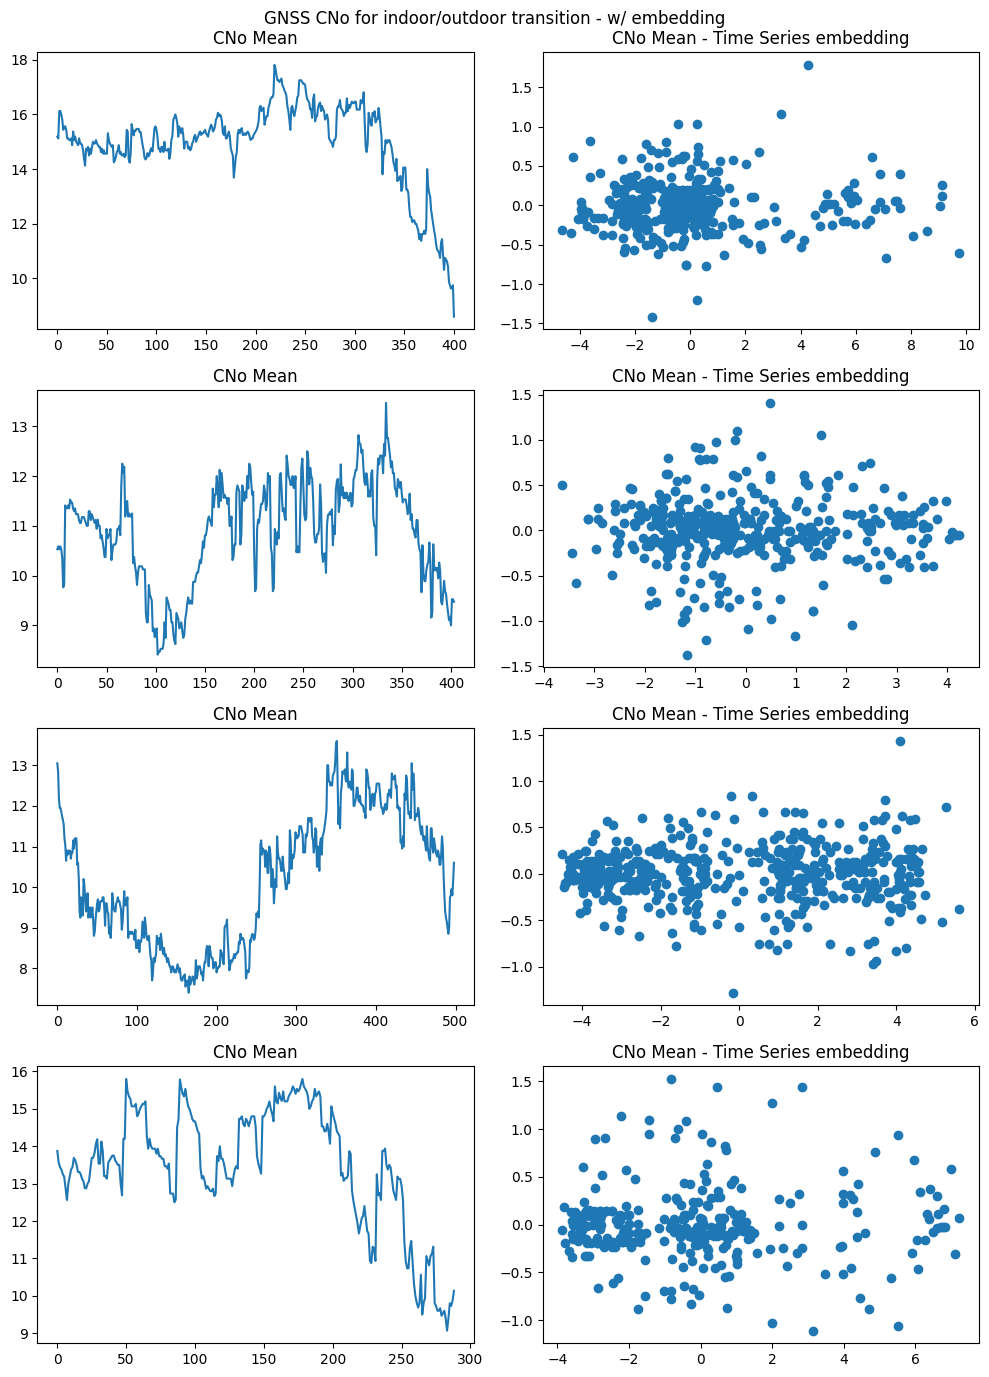

In [23]:
FILES_TO_PLOT = [
    f1_gnss_features,
    f2_gnss_features,
    f3_gnss_features,
    f4_gnss_features
]

EMBEDDINGS_TO_PLOT = [
    f1_cno_mean_embedded_all_pca,
    f2_cno_mean_embedded_all_pca,
    f3_cno_mean_embedded_all_pca,
    f4_cno_mean_embedded_all_pca
]


fig, axs = matpyplot.subplots(
    nrows=len(FILES_TO_PLOT),
    ncols=2,
    figsize=(10, 14)
)
fig.suptitle('GNSS CNo for indoor/outdoor transition - w/ embedding')
for n, axi in enumerate(axs):
    axi[0].plot(range(0, len(FILES_TO_PLOT[n])), FILES_TO_PLOT[n][:, 0])
    axi[1].scatter(EMBEDDINGS_TO_PLOT[n][:, 0], EMBEDDINGS_TO_PLOT[n][:, 1])

    axi[0].set_title(FEATURES_NAMES[0])
    axi[1].set_title(f'{FEATURES_NAMES[0]} - Time Series embedding')

matpyplot.tight_layout()

#### Displaying the embedding (coloring the times)

In [24]:
# Dividing the original features and the time embeddings in 10-sec windows

## Getting the indices to separate the groups
### For File 1
f1_tensec_indx_sep = numpy.arange(0, len(f1_gnss_features), 30)[1:]
### For File 2
f2_tensec_indx_sep = numpy.arange(0, len(f2_gnss_features), 30)[1:]
### For File 3
f3_tensec_indx_sep = numpy.arange(0, len(f3_gnss_features), 30)[1:]
### For File 4
f4_tensec_indx_sep = numpy.arange(0, len(f4_gnss_features), 30)[1:]

## Spliting the original features arrays in those 10-sec windows
f1_gnss_features_10sec_grps = numpy.split(
    f1_gnss_features, f1_tensec_indx_sep
)
print(len(f1_gnss_features_10sec_grps))
f2_gnss_features_10sec_grps = numpy.split(
    f2_gnss_features, f2_tensec_indx_sep
)
print(len(f2_gnss_features_10sec_grps))
f3_gnss_features_10sec_grps = numpy.split(
    f3_gnss_features, f3_tensec_indx_sep
)
print(len(f3_gnss_features_10sec_grps))
f4_gnss_features_10sec_grps = numpy.split(
    f4_gnss_features, f4_tensec_indx_sep
)
print(len(f4_gnss_features_10sec_grps))

14
14
17
10


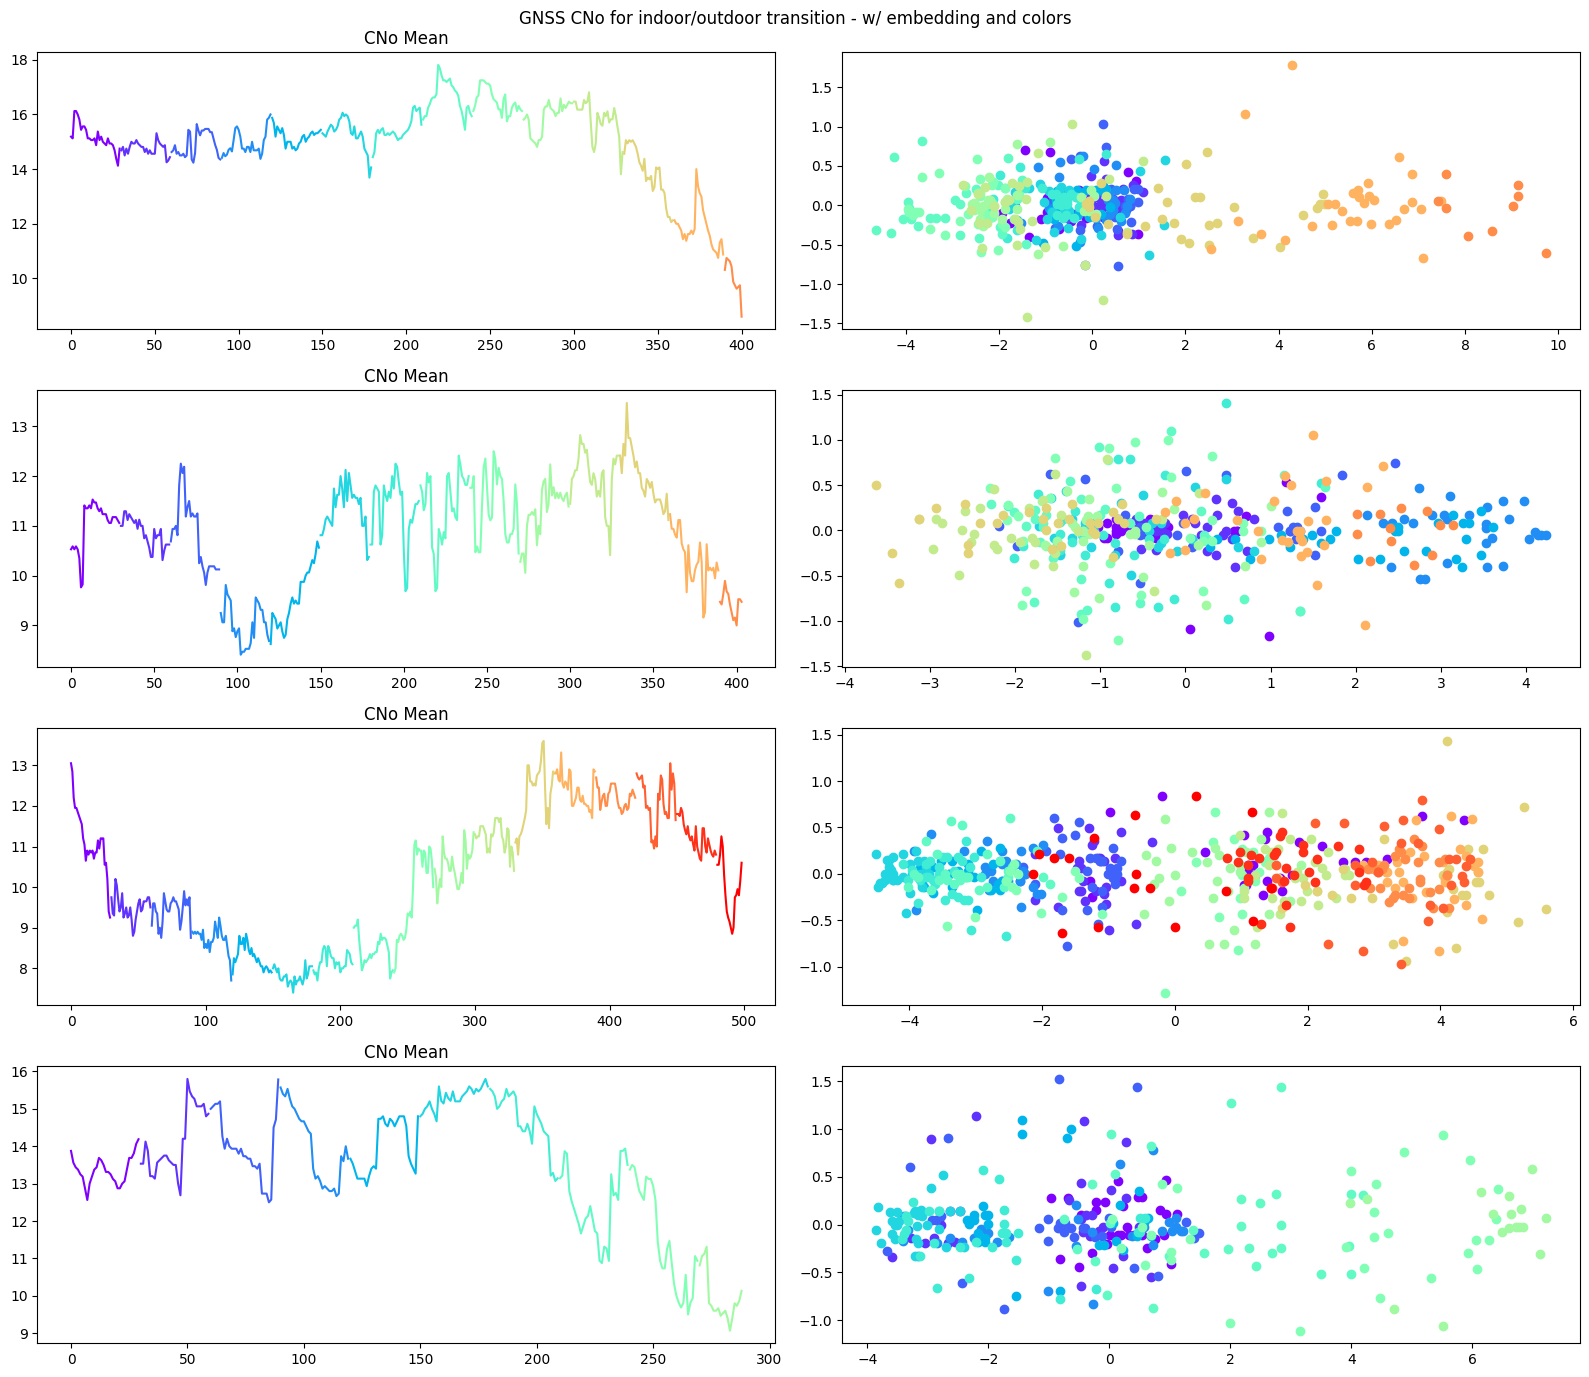

In [25]:
# Plotting the groups with a distintive color

fig, axs = matpyplot.subplots(
    nrows=len(FILES_TO_PLOT),
    ncols=2,
    figsize=(16, 14)
)
fig.suptitle('GNSS CNo for indoor/outdoor transition - w/ embedding and colors')

filepath_groups_list = [
    f1_gnss_features_10sec_grps,
    f2_gnss_features_10sec_grps,
    f3_gnss_features_10sec_grps,
    f4_gnss_features_10sec_grps
]

filepath_indexs_groups_list = [
    f1_tensec_indx_sep,
    f2_tensec_indx_sep,
    f3_tensec_indx_sep,
    f4_tensec_indx_sep
]

n_colors = max(
    [len(filepath_groups) for filepath_groups in filepath_groups_list]
)

for n, (axi, filepath_groups) in enumerate(zip(
    axs,
    filepath_groups_list,
)):
    colors = matpyplot.cm.rainbow(numpy.linspace(0, 1, n_colors))

    axi[0].set_title(FEATURES_NAMES[0])

    initial_idx_group = 0
    for n_ingroup, infile_group in enumerate(filepath_groups):
        final_group_idx = len(infile_group) + initial_idx_group
        
        axi[0].plot(
            numpy.arange(
                initial_idx_group, final_group_idx
            ),
            infile_group[:, 0],
            color=colors[n_ingroup]
        )
        axi[1].scatter(
            EMBEDDINGS_TO_PLOT[n][initial_idx_group:final_group_idx, 0],
            EMBEDDINGS_TO_PLOT[n][initial_idx_group:final_group_idx, 1],
            color=colors[n_ingroup]
        )

        initial_idx_group = final_group_idx

matpyplot.tight_layout()

# Detecting transitions using C/No and ML

In [26]:
from sklearn import svm as sklearn_svm
from sklearn.inspection import DecisionBoundaryDisplay

## Transition Detection

### 1st Step: Train the initial state

1. Get the embedding of a small window of time - 30 sec i.e.
2. Train the OC-SVM with this data
    1. Use a low nu (indicating that is not likely for out-of-state data to be in the training sample)
    2. Use a low gamma to allow the boundary to not be so close to the training sample

In [27]:
# Training data - 30 sec
print(f3_gnss_features[:90, 0].shape)
print(f3_cno_mean_embedded_train.shape)

__, f3_cno_mean_embedded_train_pca = get_2d_features_narray(
    f3_cno_mean_embedded_train
)
print(f3_cno_mean_embedded_train_pca.shape)

(90,)
(88, 3)
(88, 2)


#### Visualizing training data

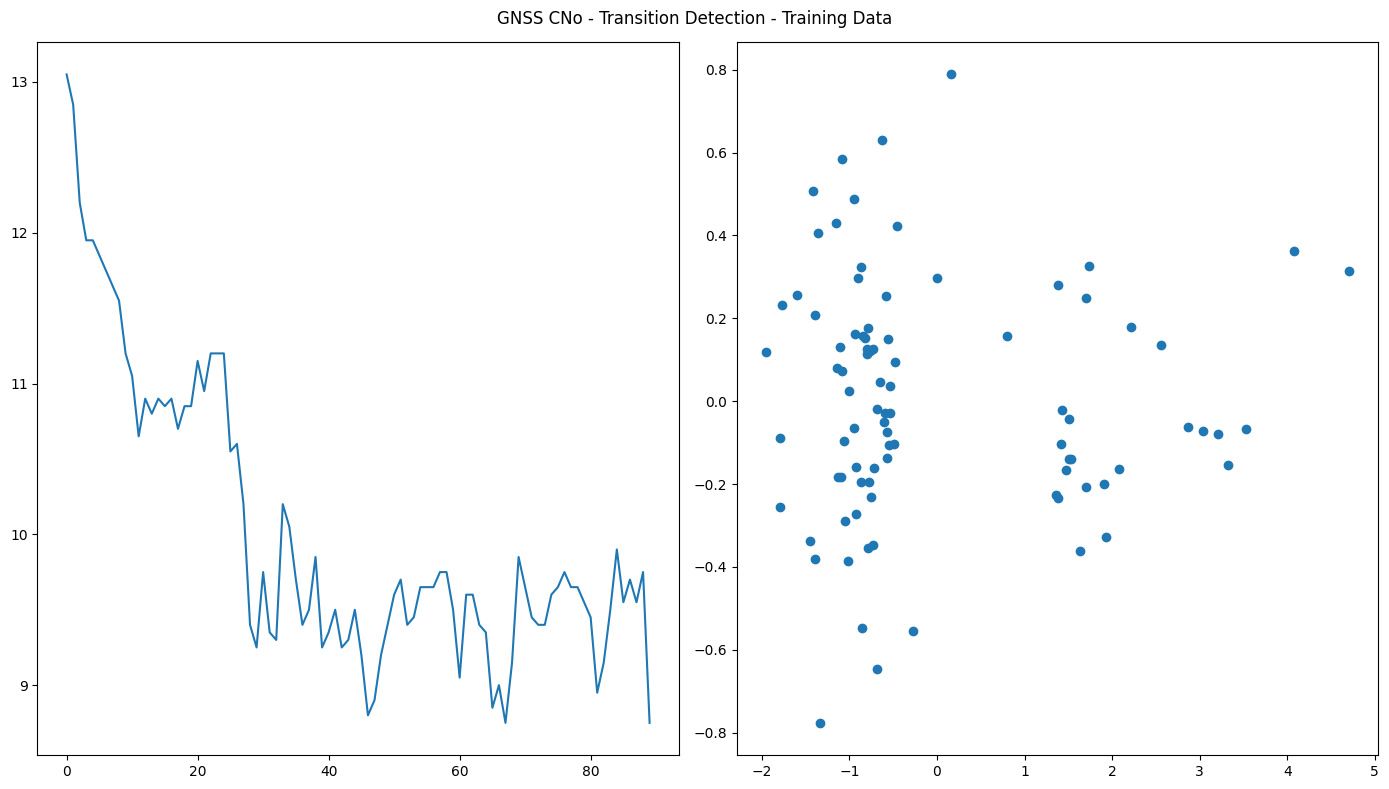

In [28]:
fig, axs = matpyplot.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 8)
)
fig.suptitle('GNSS CNo - Transition Detection - Training Data')

axs[0].plot(
    numpy.arange(0, 90),
    f3_gnss_features[:90, 0]
)
axs[1].scatter(
    f3_cno_mean_embedded_train_pca[:, 0],
    f3_cno_mean_embedded_train_pca[:, 1]
)

matpyplot.tight_layout()

##### Training the model using the training data window

This is capturing the initial state

In [29]:
f3_initial_state_model = sklearn_svm.OneClassSVM(nu=0.01, gamma=0.05)

# Fit the model to the training data
f3_initial_state_model.fit(f3_cno_mean_embedded_train)

OneClassSVM(gamma=0.05, nu=0.01)

##### Visualizing the decision boundary with the training data (using PCA)

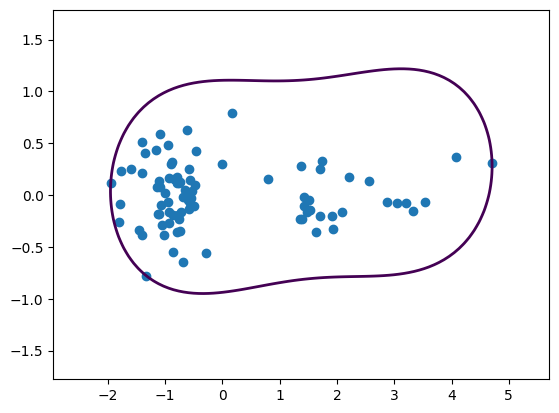

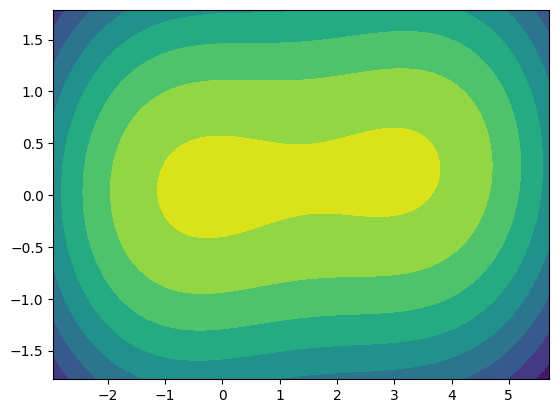

In [30]:
f3_initial_state_model_pca = sklearn_svm.OneClassSVM(nu=0.01, gamma=0.05)
# Fit the model to the training data
f3_initial_state_model_pca.fit(f3_cno_mean_embedded_train_pca)

disp = DecisionBoundaryDisplay.from_estimator(
    f3_initial_state_model_pca,
    f3_cno_mean_embedded_train_pca,
    response_method="decision_function",
    plot_method="contour",
    levels=[0],
    linewidths=2
)

disp.ax_.scatter(
    f3_cno_mean_embedded_train_pca[:, 0],
    f3_cno_mean_embedded_train_pca[:, 1]
)

disp.plot()

### 2nd Step: Score (Predict) the samples captured after training

1. Get the embedding of the remaining data (sliding window approach)
2. Predict and score the result of the samples with the initial state model

In [31]:
print(f3_gnss_features[90:, 0].shape)
print(f3_cno_mean_embedded_all[90:].shape)
print(f3_cno_mean_embedded_all_pca[90:].shape)

(409,)
(407, 3)
(407, 2)


In [32]:
# Getting the predictions for the remaining data (not training)
f3_cno_mean_embedded_cap = f3_initial_state_model.predict(
    f3_cno_mean_embedded_all[90:]
)
print(f3_cno_mean_embedded_cap.shape)

# Getting the scores for the remaining data
f3_cno_mean_embedded_cap_scores = f3_initial_state_model.score_samples(
    f3_cno_mean_embedded_all[90:]
)
print(f3_cno_mean_embedded_cap_scores.shape)

(407,)
(407,)


#### Apply the prediction and scoring to the PCA data

In [33]:
# Getting the predictions for the remaining data (not training)
f3_cno_mean_embedded_pca_cap = f3_initial_state_model_pca.predict(
    f3_cno_mean_embedded_all_pca[90:]
)
print(f3_cno_mean_embedded_pca_cap.shape)

# Getting the scores for the remaining data
f3_cno_mean_embedded_pca_cap_scores = f3_initial_state_model_pca.score_samples(
    f3_cno_mean_embedded_all_pca[90:]
)
print(f3_cno_mean_embedded_pca_cap_scores.shape)

(407,)
(407,)


##### Also the training samples

In [34]:
# Getting the predictions for the remaining data (not training)
f3_cno_mean_embedded_pca_cap_train = f3_initial_state_model_pca.predict(
    f3_cno_mean_embedded_train_pca[:90]
)
print(f3_cno_mean_embedded_pca_cap_train.shape)

# Getting the scores for the remaining data
f3_cno_mean_embedded_pca_cap_scores_train = (
    f3_initial_state_model_pca.score_samples(
        f3_cno_mean_embedded_train_pca[:90]
    )
)
print(f3_cno_mean_embedded_pca_cap_scores_train.shape)

(88,)
(88,)


### Visualize prediction and score against training data (using PCA)

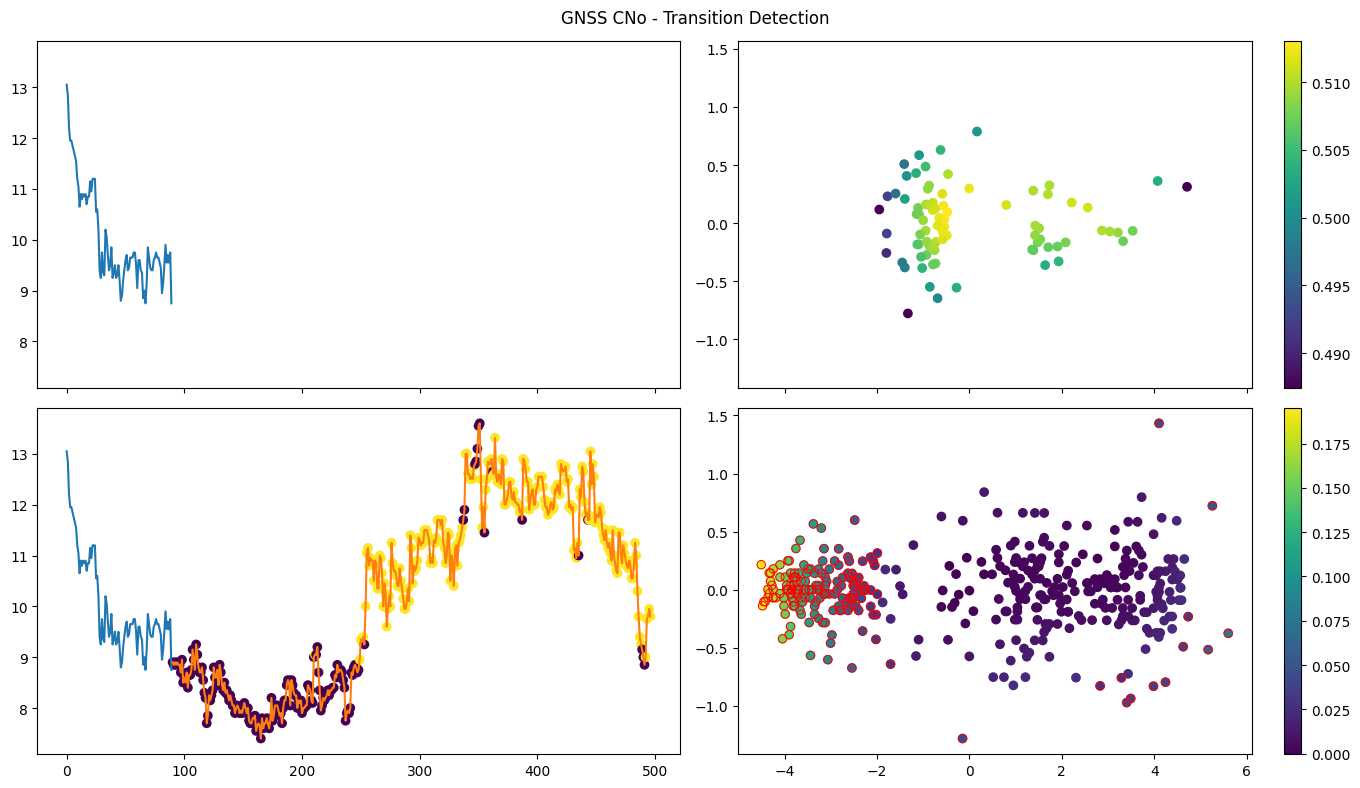

In [35]:
fig, axs = matpyplot.subplots(
    nrows=2,
    ncols=2,
    figsize=(14, 8),
    sharex='col',
    sharey='col'
)
fig.suptitle('GNSS CNo - Transition Detection')
fig.subplots_adjust(hspace=0.3)

colormap = numpy.array(['r', 'g'])

axs[0][0].plot(
    numpy.arange(0, 90),
    f3_gnss_features[:90, 0],
)
embedded_pca_train = axs[0][1].scatter(
    f3_cno_mean_embedded_train_pca[:, 0],
    f3_cno_mean_embedded_train_pca[:, 1],
    c=f3_cno_mean_embedded_pca_cap_scores_train,
    cmap="viridis"
)
fig.colorbar(embedded_pca_train, ax=axs[0][1])

axs[1][0].plot(
    numpy.arange(0, 90),
    f3_gnss_features[:90, 0],
)
axs[1][0].plot(
    numpy.arange(90, 90 + len(f3_gnss_features[90:, 0]) - 2),
    f3_gnss_features[90:-2, 0],
)
axs[1][0].scatter(
    numpy.arange(90, 90 + len(f3_gnss_features[90:, 0]) - 2),
    f3_gnss_features[90:-2, 0],
    c=f3_cno_mean_embedded_pca_cap
)

# Computing Anomaly Scores for prediction (MAX - f(x))
f3_cno_mean_anomaly_score = (
    max(f3_cno_mean_embedded_pca_cap_scores_train) - f3_cno_mean_embedded_pca_cap_scores
)
embedded_pca = axs[1][1].scatter(
    f3_cno_mean_embedded_all_pca[90:, 0],
    f3_cno_mean_embedded_all_pca[90:, 1],
    c=f3_cno_mean_anomaly_score,
    cmap="viridis"
)
fig.colorbar(embedded_pca, ax=axs[1][1])
axs[1][1].scatter(
    f3_cno_mean_embedded_all_pca[90:, 0][f3_cno_mean_embedded_pca_cap < 1],
    f3_cno_mean_embedded_all_pca[90:, 1][f3_cno_mean_embedded_pca_cap < 1],
    facecolors='none',
    edgecolors='r',
    linewidths=0.7,
)

matpyplot.tight_layout()

### Simulate reading the values from the sensor 

In [36]:
def embed_training_data(input_dataset, dimensions, delay=1):
    embed_input_dataset = numpy.lib.stride_tricks.sliding_window_view(
        input_dataset,
        dimensions
    )
    return embed_input_dataset

In [37]:
def training_ocsvm_from_narray(training_dataset, nu=0.01, gamma=0.05):
    ocsvm_model = sklearn_svm.OneClassSVM(nu=nu, gamma=gamma)
    # Fit the model to the training data
    ocsvm_model.fit(training_dataset)

    return ocsvm_model

##### State Flags

- 0 -> Not Initialized
- 1 -> Outdoors
- 2 -> Transition
- 3 -> Indoors

In [38]:
TRAINING_SAMPLES_N = 90
samples_count = 0

# The windows size is equal to 1 sec
WINDOW_SIZE = 3
FEATURE_SAMPLES_WINDOW = deque([0, 0, 0], 3)
CONSECUTIVE_SAMPLES_FOR_CHANGE = WINDOW_SIZE * 2

TRAINING_SET = []

INITIAL_MODEL_SET = False

CURRENT_STATE = 0
OLD_STATE = 0

pos_trans_det_count = 0
neg_trans_det_count = 0

for feature_reading in f3_gnss_features[:, 0]:
    # window_position = samples_count % WINDOW_SIZE

    FEATURE_SAMPLES_WINDOW.appendleft(feature_reading)

    if (
        samples_count < TRAINING_SAMPLES_N 
    ):
        TRAINING_SET.append(feature_reading)

    else:

        input_dataset = numpy.array(TRAINING_SET)
        if not INITIAL_MODEL_SET:
            # TRAIN THE MODEL
            training_dataset = embed_training_data(
                input_dataset=input_dataset,
                dimensions=3
            )
            initial_model = training_ocsvm_from_narray(training_dataset)

            training_scores = initial_model.decision_function(
                training_dataset
            )
            max_training_score = training_scores.max()
            min_training_score = training_scores.min()
            print(f'Max decision function score {max_training_score}')
            print(f'Min decision function score {min_training_score}')
            print(
                'Anomaly score between max and min '
                f'train {max_training_score - min_training_score}'
            )

            INITIAL_MODEL_SET = True
            CURRENT_STATE = 1

        else:
            features_window_list = numpy.array(
                FEATURE_SAMPLES_WINDOW
            ).reshape(1, -1)

            # If the current reading is higher than the max value,
            # then no need to do inference, otherwise use the model
            if feature_reading < input_dataset.max():

                transition_detection = initial_model.predict(
                    features_window_list
                )
                transition_raw_score = initial_model.decision_function(
                    features_window_list
                )

                if transition_detection > 0:
                    pos_trans_det_count += 1
                    neg_trans_det_count = 0

                    if pos_trans_det_count == CONSECUTIVE_SAMPLES_FOR_CHANGE:
                        CURRENT_STATE = 1
                else:
                    pos_trans_det_count = 0
                    neg_trans_det_count += 1

                    if neg_trans_det_count == CONSECUTIVE_SAMPLES_FOR_CHANGE:
                        CURRENT_STATE = 2
                        transition_mark = samples_count

    if CURRENT_STATE != OLD_STATE:
        print(
            f'The current state is: {CURRENT_STATE} '
            f'at reading {samples_count}'
        )
        OLD_STATE = CURRENT_STATE

    samples_count = samples_count + 1

    # if samples_count > 96:
    #     break

Max decision function score 0.025838953412018417
Min decision function score -4.396143332452418e-05
Anomaly score between max and min train 0.02588291484534294
The current state is: 1 at reading 90
The current state is: 2 at reading 100
The current state is: 1 at reading 261
The current state is: 2 at reading 354
The current state is: 1 at reading 379
The current state is: 2 at reading 427
The current state is: 1 at reading 438


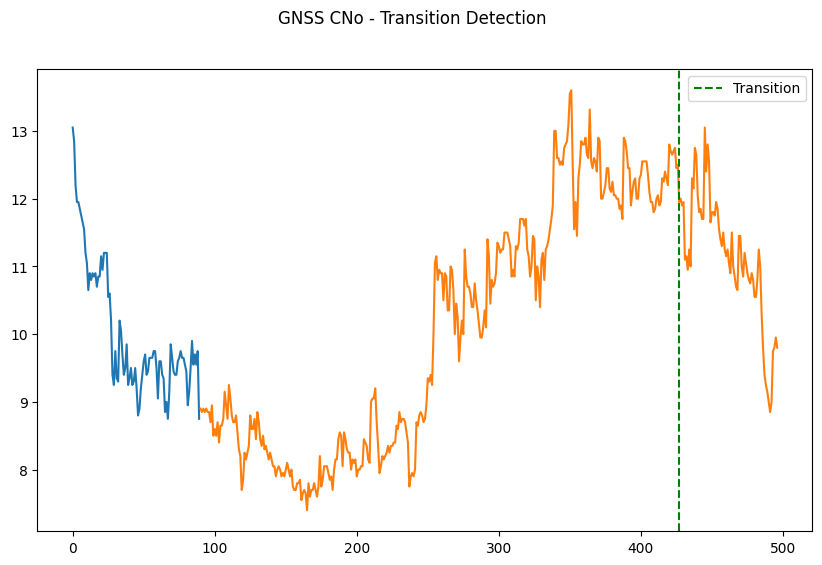

In [39]:
fig, axs = matpyplot.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)
fig.suptitle('GNSS CNo - Transition Detection')

axs.plot(
    numpy.arange(0, 90),
    f3_gnss_features[:90, 0],
)
axs.plot(
    numpy.arange(90, 90 + len(f3_gnss_features[90:, 0]) - 2),
    f3_gnss_features[90:-2, 0],
)
axs.axvline(x=transition_mark, c='green', label='Transition', linestyle='--')
axs.legend()


### Establishing the transitions
1. The detection from outdoors to transition is given by the model
2. From the transition state to indoors the detection uses the receiver data (No FIX, Low or Non-existent PDOP)

# Applying the transition detection strategy to other files

In [40]:
def computing_transition_detection_mark(
        file_gnss_features,
        training_samples_n=90,
        window_size=3
):
    TRAINING_SAMPLES_N = training_samples_n
    samples_count = 0

    # The windows size is equal to 1 sec
    WINDOW_SIZE = window_size
    FEATURE_SAMPLES_WINDOW = deque([0, 0, 0], window_size)
    CONSECUTIVE_SAMPLES_FOR_CHANGE = WINDOW_SIZE * 2

    TRAINING_SET = []

    INITIAL_MODEL_SET = False

    CURRENT_STATE = 0
    OLD_STATE = 0

    pos_trans_det_count = 0
    neg_trans_det_count = 0

    for feature_reading in file_gnss_features[:, 0]:
        # window_position = samples_count % WINDOW_SIZE

        FEATURE_SAMPLES_WINDOW.appendleft(feature_reading)

        if (
            samples_count < TRAINING_SAMPLES_N 
        ):
            TRAINING_SET.append(feature_reading)

        else:

            input_dataset = numpy.array(TRAINING_SET)
            if not INITIAL_MODEL_SET:
                # TRAIN THE MODEL
                training_dataset = embed_training_data(
                    input_dataset=input_dataset,
                    dimensions=window_size
                )
                initial_model = training_ocsvm_from_narray(training_dataset)

                training_scores = initial_model.decision_function(
                    training_dataset
                )
                max_training_score = training_scores.max()
                min_training_score = training_scores.min()
                print(f'Max decision function score {max_training_score}')
                print(f'Min decision function score {min_training_score}')
                print(
                    'Anomaly score between max and min '
                    f'train {max_training_score - min_training_score}'
                )

                INITIAL_MODEL_SET = True
                CURRENT_STATE = 1

            else:
                features_window_list = numpy.array(
                    FEATURE_SAMPLES_WINDOW
                ).reshape(1, -1)

                # If the current reading is higher than the max value,
                # then no need to do inference, otherwise use the model
                if feature_reading < input_dataset.max():

                    transition_detection = initial_model.predict(
                        features_window_list
                    )
                    # transition_raw_score = initial_model.decision_function(
                    #     features_window_list
                    # )

                    if transition_detection > 0:
                        pos_trans_det_count += 1
                        neg_trans_det_count = 0

                        if pos_trans_det_count == CONSECUTIVE_SAMPLES_FOR_CHANGE:
                            CURRENT_STATE = 1
                    else:
                        pos_trans_det_count = 0
                        neg_trans_det_count += 1

                        if neg_trans_det_count == CONSECUTIVE_SAMPLES_FOR_CHANGE:
                            CURRENT_STATE = 2
                            transition_mark = samples_count

        if CURRENT_STATE != OLD_STATE:
            print(
                f'The current state is: {CURRENT_STATE} '
                f'at reading {samples_count}'
            )
            OLD_STATE = CURRENT_STATE

        samples_count = samples_count + 1

    return transition_mark

## For Filepath 1

### Getting the transition mark

In [41]:
f1_offset = 0

f1_transition_mark = computing_transition_detection_mark(
    file_gnss_features=f1_gnss_features[f1_offset:],
    training_samples_n=90,
    window_size=3
)
print(f1_transition_mark)

Max decision function score 0.0656319145221772
Min decision function score -3.954399141470333e-09
Anomaly score between max and min train 0.06563191847657635
The current state is: 1 at reading 90
The current state is: 2 at reading 345
345


### Plotting the detection

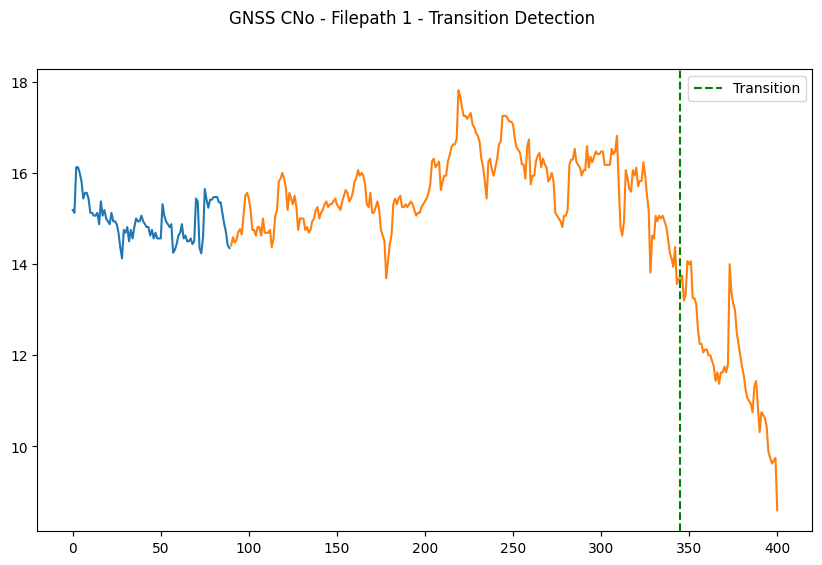

In [42]:
fig, axs = matpyplot.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)
fig.suptitle('GNSS CNo - Filepath 1 - Transition Detection')

axs.plot(
    numpy.arange(0, 90),
    f1_gnss_features[:90, 0],
)
axs.plot(
    numpy.arange(90, 90 + len(f1_gnss_features[90:, 0])),
    f1_gnss_features[90:, 0],
)
axs.axvline(
    x=f1_transition_mark, c='green', label='Transition', linestyle='--'
)
axs.legend()

## For Filepath 2

(Flipped)

### Preparing data

In [43]:
f2_gnss_features_flipped = numpy.flipud(f2_gnss_features[:-10])
print(f2_gnss_features_flipped.shape)

(394, 2)


### Getting the transition mark

In [44]:
f2_transition_mark = computing_transition_detection_mark(
    file_gnss_features=f2_gnss_features,
    training_samples_n=90,
    window_size=3
)
print(f2_transition_mark)

Max decision function score 0.08585780945685328
Min decision function score -0.0001243954972286465
Anomaly score between max and min train 0.08598220495408193
The current state is: 1 at reading 90
The current state is: 2 at reading 96
The current state is: 1 at reading 147
The current state is: 2 at reading 395
395


### Plotting the detection

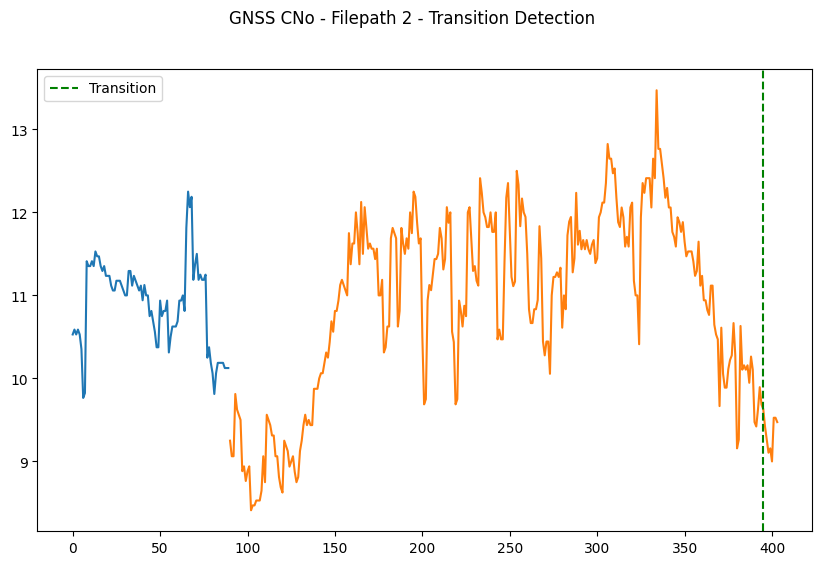

In [45]:
fig, axs = matpyplot.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)
fig.suptitle('GNSS CNo - Filepath 2 - Transition Detection')

axs.plot(
    numpy.arange(0, 90),
    f2_gnss_features[:90, 0],
)
axs.plot(
    numpy.arange(90, 90 + len(f2_gnss_features[90:, 0])),
    f2_gnss_features[90:, 0],
)
axs.axvline(
    x=f2_transition_mark, c='green', label='Transition', linestyle='--'
)
axs.legend()

## For Filepath 4

(Flipped)

### Preparing data

In [46]:
f4_gnss_features_flipped = numpy.flipud(f4_gnss_features)
print(f4_gnss_features_flipped.shape)

(289, 2)


### Getting the transition mark

In [47]:
f4_transition_mark = computing_transition_detection_mark(
    file_gnss_features=f4_gnss_features,
    training_samples_n=90,
    window_size=3
)
print(f4_transition_mark)

Max decision function score 0.08958427401522495
Min decision function score -0.0003209942868511728
Anomaly score between max and min train 0.08990526830207612
The current state is: 1 at reading 90
The current state is: 2 at reading 221


The current state is: 1 at reading 239
The current state is: 2 at reading 257
257


### Plotting the detection

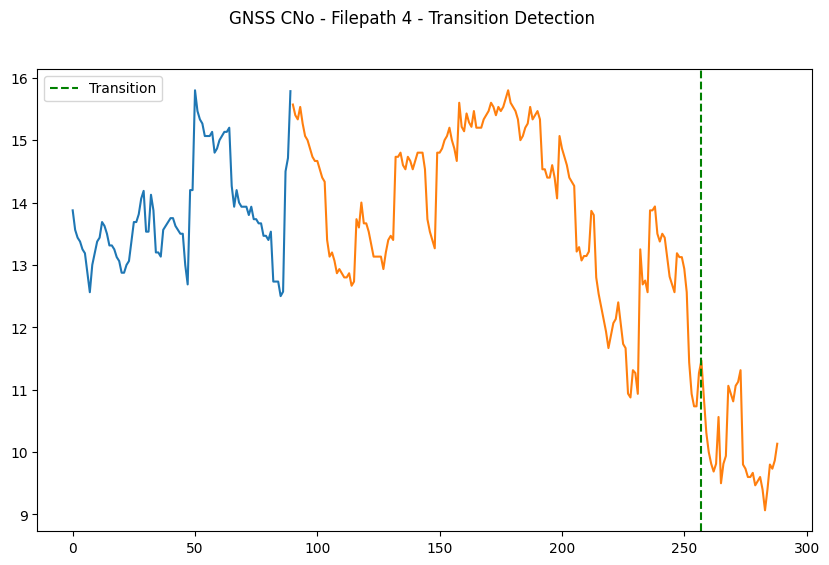

In [48]:
fig, axs = matpyplot.subplots(
    nrows=1,
    ncols=1,
    figsize=(10, 6),
)
fig.suptitle('GNSS CNo - Filepath 4 - Transition Detection')

axs.plot(
    numpy.arange(0, 90),
    f4_gnss_features[:90, 0],
)
axs.plot(
    numpy.arange(90, 90 + len(f4_gnss_features[90:, 0])),
    f4_gnss_features[90:, 0],
)
axs.axvline(
    x=f4_transition_mark, c='green', label='Transition', linestyle='--'
)
axs.legend()